# 1. Import bibliotek

In [1]:
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.base import BaseEstimator, TransformerMixin
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from copy import copy
import gensim.models.keyedvectors as word2vec
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, SimpleRNN, Activation, LSTM, GRU, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras import optimizers
from keras.callbacks import EarlyStopping

/Users/Ewel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 2. Import danych

In [2]:
def importuj_csv(path, name):
    data_out = pd.read_csv(path + '/' + name, \
               sep='\t+', header=None, names=["Sentence", "Target"], )
    return data_out

In [3]:
path = 'sentiment labelled sentences'

imdb = importuj_csv(path, 'imdb_labelled.txt')
yelp = importuj_csv(path, 'yelp_labelled.txt')
amazon = importuj_csv(path, 'amazon_cells_labelled.txt')

/Users/Ewel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


# 3. Podstawowe sprawdzenie danych

### Sprawdzenie kształtu danych

In [4]:
print(amazon.shape)
print(imdb.shape)
print(yelp.shape)

(1000, 2)
(1000, 2)
(1000, 2)


### Łączenie zbiorów (zgodnie z treścią zadania) + print podstawowych informacji

In [5]:
dane = pd.concat([imdb, yelp, amazon], axis=0, ignore_index=True)
print(dane.head())
print(dane.dtypes)
print(dane.shape)

                                            Sentence  Target
0  A very, very, very slow-moving, aimless movie ...       0
1  Not sure who was more lost - the flat characte...       0
2  Attempting artiness with black & white and cle...       0
3       Very little music or anything to speak of.         0
4  The best scene in the movie was when Gerardo i...       1
Sentence    object
Target       int64
dtype: object
(3000, 2)


### Sprawdzenie czy w zbiorze są braki

In [6]:
np.sum(dane.isnull().any(axis=1))

0

### Sprawdzenie najczęściej występujących słów dla negatywnych opinii

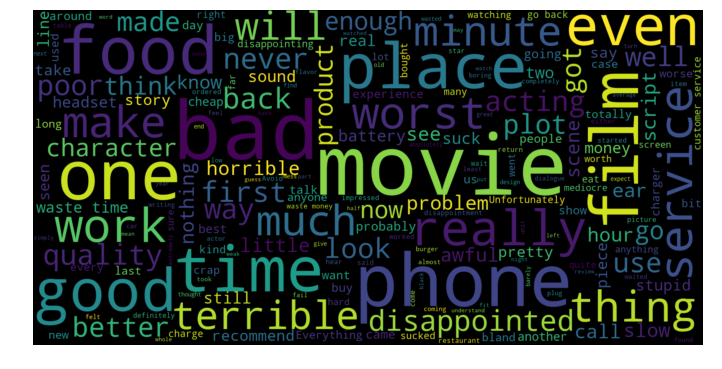

In [7]:
#Wybieram negatywne opinie i tworzę Serię ze słów występujących w komentarzach
negatives = dane[dane.Target == 0]
neg_string = []
for t in negatives.Sentence:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

#Korzystam z biblioteki WordCloud i  rysuję obrazek, gdzie wielkość słów jest proporcjonalna do częstości występowania
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

W większości przypadków są to słowa negatywne, ale często występuje słowo 'good'. Sprawdzę co to za przypadki.

In [8]:
for t in negatives.Sentence[:200]:
    if 'good' in t:
        print(t)

The performances are not improved by improvisation, because the actors now have twice as much to worry about: not only whether they're delivering the line well, but whether the line itself is any good.  
And, quite honestly, often its not very good.  
The directing and the cinematography aren't quite as good.  
It was a good thing that the tickets only cost five dollars because I would be mad if I'd have paid $7.50 to see this crap.  
This is a bad film, with bad writing, and good actors....an ugly cartoon crafted by Paul Haggis for people who can't handle anything but the bold strokes in storytelling....a picture painted with crayons.  
I was left shattered from the experience of watching this 'film' and I took a good two hours to fully recover.  
I certainly do not mean this distinction in a good way.  
This would not even be good as a made for TV flick.  
If it was to turn my good day feeling into a night of disturbing memories than I guess he succeeded.  


Jak widać good występuje często z zaprzeczeniem - to sugeruje, że warto w analizach uwzględniać 
nie tylko pojedyńcze słowa, ale również wstępowanie innych słów w ich otoczeniu.

### Sprawdzenie najczęściej występujących słów dla pozytywnych opinii

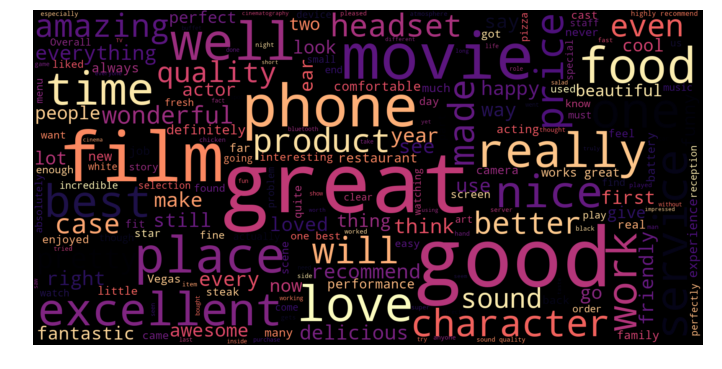

In [9]:
positives = dane[dane.Target == 1]
pos_string = []

for t in positives.Sentence:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

Dominują pozytywne słowa: great, good, excellent, love.

### Sprawdzenie długości komentarzy 

In [10]:
#Tworznie obiektów z długością komentarzy + rozróżnienie na pozytywne i negatywne
dlugosc = dane['Sentence'].apply(len)
dlugosc_pos = positives['Sentence'].apply(len)
dlugosc_neg = negatives['Sentence'].apply(len)

dlugosc.shape


(3000,)

#### Histogram długości komentarzy

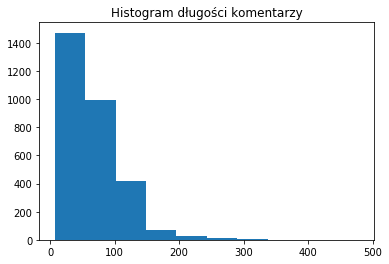

In [11]:
plt.hist(dlugosc)
plt.title("Histogram długości komentarzy")
plt.show()

Widać, że rozkład jest prawoskośny, większość komentarzy ma długość nie większą niż 200 znaków.

#### Histogram długości komentarzy ze względu na wydzwięk 

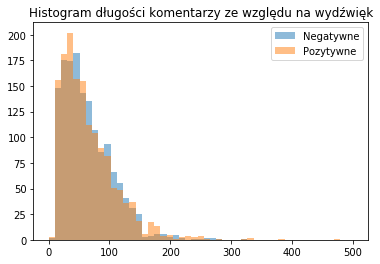

In [12]:
bins = np.linspace(0, 500, 50)
plt.hist(dlugosc_neg, bins= bins, alpha=0.5, label = "Negatywne")
plt.hist(dlugosc_pos, bins = bins, alpha=0.5, label = "Pozytywne")

plt.title("Histogram długości komentarzy ze względu na wydźwięk")
plt.legend()
plt.show()

Nie można zauważyć jednoznacznej tendencji - długość komentarza raczej nie wpływa na jego wydźwięk.

# 4. Podział na zbiór uczący i testowy

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dane.Sentence,dane.Target, test_size=0.3, random_state=20)
print(X_test.shape)
print(X_train.shape)

(900,)
(2100,)


#### Sprawdzenie czy próbka jest zbilansowana 

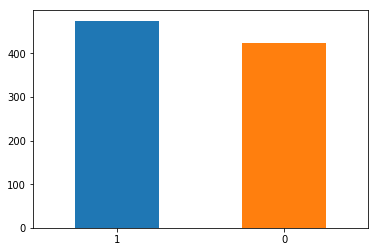

In [14]:
y_test.value_counts().plot(kind="bar", rot=0)

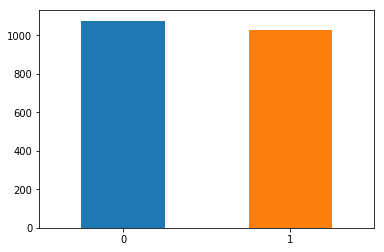

In [15]:
y_train.value_counts().plot(kind="bar", rot=0)

Widać, że udział komentarzy pozytywnych oraz negatywnych jest podobny - próbka zbilansowana. Nie ma potrzeby przeważenia obserwacji, czy wprowadzania innego progu niż 0.5 przy predykcji zmiennej celu.

# 5. Przetworzenie i reprezentacja danych

## Definicja klas do przetworzenia zbioru

### Zamiana na małe litery

In [16]:
class Male_Litery(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        wynik = [a.lower() for a in X]
        return(wynik)

#### Check

In [17]:
sc=Male_Litery()
wynik1 = sc.fit_transform(X_train)
wynik1[:10]

['i wish i could return the unit and get back my money.',
 "another note about this phone's appearance is that it really looks rather bland, especially in the all black model.",
 'back to good bbq, lighter fare, reasonable pricing and tell the public they are back to the old ways.',
 'worst martini ever!',
 'just had lunch here and had a great experience.',
 'i swung in to give them a try but was deeply disappointed.',
 'great bluetooth!.',
 'this is cool because most cases are just open there allowing the screen to get all scratched up.',
 'great earpiece.',
 'the burger... i got the "gold standard" a $17 burger and was kind of disappointed.']

### Usuwanie punktacji

In [18]:
class Usun_Punktacje(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        table = str.maketrans({key: None for key in string.punctuation})
        wynik = [a.translate(table) for a in X]
        return(wynik)

### Tokenizacja + usuwanie stopwords

In [19]:
class Tokenize(TransformerMixin, BaseEstimator):
    
    def __init__(self, remove_stopwords=True):
        self.remove_stopwords=remove_stopwords
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        wynik = [nltk.word_tokenize(a) for a in X]
        
        if self.remove_stopwords:
            stopwords = nltk.corpus.stopwords.words("english")
            wynik = [[w for w in a if w not in stopwords] for a in wynik]
            
        return(wynik)

#### Check

In [20]:
sc=Tokenize()
wynik1 = sc.fit_transform(X_train)
print(len(wynik1))
wynik1[:2]

2100


[['I', 'wish', 'I', 'could', 'return', 'unit', 'get', 'back', 'money', '.'],
 ['Another',
  'note',
  'phone',
  "'s",
  'appearance',
  'really',
  'looks',
  'rather',
  'bland',
  ',',
  'especially',
  'black',
  'model',
  '.']]

### Usuwanie końcówek

In [21]:
class Stemmer(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        stemmer = nltk.PorterStemmer()
        wynik = [[stemmer.stem(w) for w in a] for a in X]
       
        return(wynik)

### Łączenie słów w zdania - do dalszego przetwarzania

In [22]:
class Join_Sentences(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        wynik = [" ".join(a) for a in X]
        return(wynik)

## Przekształcenie SVD - redukcja wymiaru

### Check 

Sprawdzenie, jak kształtują się wartości diagonalne w macierzy $\Sigma$ dla przykładowego przekształcenia - wartości te mówią o tym, jak bardzo ważna jest dana cecha. Jeśli wykres tych wartości wypłaszcza się w pewnym momencie, to można na takim wymiarze się zatrzymać i uciąć resztę przekształconych cech. 

Tworzę pipeline z poprzednio zdefiniowanych klas.
Na końcu dodaje countvectorizer - zamienia zdania na słowa i tworzy macierz, gdzie każdy wiersz odpowiada
każdemu komentarzowi, a każda kolumna wyrazowi, opcja binary =F alse oznacza, że chcę zliczać częstość występowania słowa w komentarzu.

Stosuję przekształcenie SVD, gdyż macierz stworzona na podstawie takiej reprezentacji danych jest bardzo duża - stąd, aby przyspieszyć proces uczenia potrzbujemy zredukować wymiar.

In [23]:
przygotowanie_danych1 = make_pipeline(Male_Litery(), 
                            Usun_Punktacje(),
                            Tokenize(remove_stopwords=True),
                            Stemmer(),
                            Join_Sentences()
                            ,CountVectorizer(token_pattern='(?u)\\b\\w+\\b',min_df=3,max_df=0.5, binary=False)
                            )
X_train_1 = przygotowanie_danych1.fit_transform(X_train)
X_test_1 = przygotowanie_danych1.transform(X_test)
# Sprawdzenie ile razy maksymalnie wystąpiło to samo słowo w jednym komentarzu
X_train_1.max()

4

Przekształcenie danych oraz rysowanie wykresu z wartościami diagonanymi

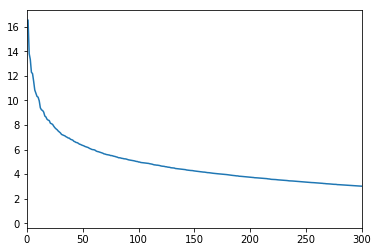

In [24]:
U, s, V = np.linalg.svd(X_train_1.todense())
S = np.zeros_like(X_train_1.todense()).astype("float")
np.fill_diagonal(S,s)
plt.plot(range(1,len(s)+1),s)
plt.xlim(0,300)
plt.show()

Na podstawie wykresu widać, że do ok 50 cechy wartości gwałtownie spadają, później spadek wartości jest łagodniejszy.

Wybieram dla przykładu 50 cech - dopasowuję przekształcenie na danych treningowych i aplikuję je na dane testowe oraz treningowe. Sprawdzam, czy wymiar faktycznie zredukował się do 50 oraz sprawdzam jaką część wariancji zmiennych (informacji zawartych w danych) wyjaśniają wybrane 50 zmodyfikowane cechy.

In [25]:
svd = TruncatedSVD(n_components=50)
svd.fit(X_train_1.todense())
result_train = svd.transform(X_train_1.todense())
result_test = svd.transform(X_test_1.todense())
print("Wymiar początkowy: {}".format(X_train_1.shape))
print("Wymiar po transformacji: {}".format(result_train.shape))
explained_variance = svd.explained_variance_ratio_.sum()
print("Suma wyjaśnionej wariancji: %d%%" % (int(explained_variance * 100)))

Wymiar początkowy: (2100, 952)
Wymiar po transformacji: (2100, 50)
Suma wyjaśnionej wariancji: 35%


## Pipeline do przygotowania danych
### 1. CountVectorizer

Pierwsza wersja pipeline: zdefiniowane przeze mnie klasy + Countvectorizer (zlicza występowanie słów) + Przekształcenie SVD

In [26]:
przygotowanie_danych1 = make_pipeline(Male_Litery(), 
                            Usun_Punktacje(),
                            Tokenize(remove_stopwords=True),
                            Stemmer(),
                            Join_Sentences(),
                            CountVectorizer(token_pattern='(?u)\\b\\w+\\b'),
                            TruncatedSVD()
                            )

### 2. Przekształcenie Tfidf

Druga wersja - różni się od pierwszej wykorzystaniem przekształcenia TFIDF - który patrzy na relatywną częstość i rzadkość występowania słowa.

In [27]:
przygotowanie_danych2 = make_pipeline(Male_Litery(), 
                            Usun_Punktacje(),
                            Tokenize(remove_stopwords=True),
                            Stemmer(),
                            Join_Sentences(),
                            TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'),
                            TruncatedSVD()
                            )

# 6. Modele podstawowe

## Definicja modeli

Modele, które będę analizować - podstawowe: regresja logistyczna, drzewa decyzyjne oraz lasy losowe - wszystkie modele w dwóch wersjach przekształceń.

Tworzę odpowiednie pipeliny oraz listę zdefiniowanych przeze mnie modeli.

In [28]:
model1 = make_pipeline(przygotowanie_danych1, LogisticRegression())
model2 = make_pipeline(przygotowanie_danych2, LogisticRegression())
model3 = make_pipeline(przygotowanie_danych1, DecisionTreeClassifier())
model4 = make_pipeline(przygotowanie_danych2, DecisionTreeClassifier())
model5 = make_pipeline(przygotowanie_danych1, RandomForestClassifier())
model6 = make_pipeline(przygotowanie_danych2, RandomForestClassifier())

models = [model1, model2, model3, model4, model5, model6]
names = ['count_logistic', 'tfi_logistic', 'count_tree', 'tfi_tree', 'count_forest', 'tfi_forest']

## Gridsearch do szukania najlepszych parametrów

### Definiowanie parametrów

Definiuję parametry, po których będę szukać optymalnych przekształceń i modeli.

In [29]:
# 1.Maksymalny odsetek występowania słowa w tekście
max_df = [0.5, 0.6, 0.7, 0.8, 0.9]

# 2. Minimalna częstość występowania 
min_df = [int(x) for x in range(1, 10)]

# 3. Częstość występowania słowa vs flaga występowania słowa
binary = [True, False]

# 4. Zakres słów traktowanych jako jedno wyrażenie do zliczania częstości
ngram_range = [(1,1), (1,2)]

# 5. Liczba komponentów w SVD
n_components = [int(x) for x in range(50, 200, 20)]

# 6. Liczba drzew w lesie losowym
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# 7. Maksymalna liczba poziomów w drzewie
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# 8. Minimalna liczba obserwacji do podziału drzewa
min_samples_split = [2, 5, 10]

# 9. Minimalna liczba obserwacji w liściu
min_samples_leaf = [1, 2, 4]

#10. Regularyzacja
penalty = ['l1', 'l2']

### Zestawy parametrów dla poszczególnych modeli

Ze względu na dużą liczbę parametrów stosuję random_grid, żeby szukać tylko po losowych wartościach ze wszystkich możliwych kombinacji parametrów.

In [30]:
random_grid_dane1 = {'pipeline__countvectorizer__max_df' : max_df,
                'pipeline__countvectorizer__min_df' : min_df,
                'pipeline__countvectorizer__binary' : binary,
                'pipeline__countvectorizer__ngram_range' : ngram_range,
                'pipeline__truncatedsvd__n_components': n_components,
               }

In [31]:
random_grid_dane2 = {'pipeline__tfidfvectorizer__max_df' : max_df,
                'pipeline__tfidfvectorizer__min_df' : min_df,
                'pipeline__tfidfvectorizer__ngram_range' : ngram_range,
                'pipeline__truncatedsvd__n_components': n_components,
               }

In [32]:
random_grid_logi = {'logisticregression__penalty': penalty}

random_grid_tree = {'decisiontreeclassifier__max_depth': max_depth,
                'decisiontreeclassifier__min_samples_split': min_samples_split,
                'decisiontreeclassifier__min_samples_leaf': min_samples_leaf
                   }
random_grid_fore = {'randomforestclassifier__n_estimators': n_estimators,
                'randomforestclassifier__max_depth': max_depth,
                'randomforestclassifier__min_samples_split': min_samples_split,
                'randomforestclassifier__min_samples_leaf': min_samples_leaf
                   }

Łączę parametry z pipeline z przygotowaniem i reprezentacją danych oraz parametry modeli w jeden zestaw parametrów.

In [33]:
random_grid1 = copy(random_grid_dane1)
random_grid1.update(random_grid_logi)

random_grid2 = copy(random_grid_dane2)
random_grid2.update(random_grid_logi)

random_grid3 = copy(random_grid_dane1)
random_grid3.update(random_grid_tree)

random_grid4 = copy(random_grid_dane2)
random_grid4.update(random_grid_tree)

random_grid5 = copy(random_grid_dane1)
random_grid5.update(random_grid_fore)

random_grid6 = copy(random_grid_dane2)
random_grid6.update(random_grid_fore)

parametry = [random_grid1, random_grid2, random_grid3, random_grid4, random_grid5, random_grid6]

#parametry = [random_grid1, random_grid2, random_grid3]

### Szukanie optymalnych parametrów dla wybranych modeli

In [35]:
best_params = []
accuracy_train = []
accuracy_test = []

for model, parametr in zip(models,parametry):
        rf_random = RandomizedSearchCV(estimator = model, param_distributions = parametr, n_iter = 10,
                               cv = 3, verbose=0, random_state=42, n_jobs = -1)
        # Do testowania wybieram Cross Walidacje - dzielenie na 3 podpróbki zbioru danych, 
        #definiuję seed oraz liczbę iteracji
        #Fit na zbiorze treningowym
        rf_random.fit(X_train, y_train)
        #Zapis najlepszych parametrów
        best_params.append(rf_random.best_params_)
        #Sprawdzenie jakości modelu (miara accuracy) na zbiorze treningowym i testowym
        accuracy_train.append(accuracy_score(y_train, rf_random.best_estimator_.predict(X_train)))
        accuracy_test.append(accuracy_score(y_test, rf_random.best_estimator_.predict(X_test)))
        

/Users/Ewel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Ewel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Print wyników

In [36]:
for model, acc_tr, acc_ts in zip(models,accuracy_train, accuracy_test):
    print("Dane: {}".format(model.steps[0][1].steps[5][0]))
    print("Model: {}".format(model.steps[1][0]))
    print("Accuracy train: {}".format(acc_tr))
    print("Accuracy test: {}".format(acc_ts))
    print("----------------------")

Dane: countvectorizer
Model: logisticregression
Accuracy train: 0.8
Accuracy test: 0.7444444444444445
----------------------
Dane: tfidfvectorizer
Model: logisticregression
Accuracy train: 0.789047619047619
Accuracy test: 0.7288888888888889
----------------------
Dane: countvectorizer
Model: decisiontreeclassifier
Accuracy train: 0.9261904761904762
Accuracy test: 0.6133333333333333
----------------------
Dane: tfidfvectorizer
Model: decisiontreeclassifier
Accuracy train: 0.9104761904761904
Accuracy test: 0.6122222222222222
----------------------
Dane: countvectorizer
Model: randomforestclassifier
Accuracy train: 0.9623809523809523
Accuracy test: 0.7211111111111111
----------------------
Dane: tfidfvectorizer
Model: randomforestclassifier
Accuracy train: 0.981904761904762
Accuracy test: 0.7277777777777777
----------------------


Najlepszy okazał się model logistycznej liniowej z przekształceniem countvectorizer - sprawdzenie jakie są optymalnie parametry.

In [72]:
best_params[0]

{'pipeline__truncatedsvd__n_components': 170,
 'pipeline__countvectorizer__ngram_range': (1, 1),
 'pipeline__countvectorizer__min_df': 4,
 'pipeline__countvectorizer__max_df': 0.6,
 'pipeline__countvectorizer__binary': True,
 'logisticregression__penalty': 'l2'}

# 7. Sieci neuronowe

## Przygotowanie danych

Do przygotowania danych wykorzystamy poprzedni pipleline.

In [38]:
przygotowanie_danych_nn = make_pipeline(Male_Litery(), 
                                        Usun_Punktacje(),
                                        Tokenize(remove_stopwords=True),
                                        Join_Sentences())

#fit tylko na danych treningowych
X_train_nn = przygotowanie_danych_nn.fit_transform(X_train)
X_test_nn = przygotowanie_danych_nn.transform(X_test)

Inna reprezentacja danych - w kolumnach macierzy mamy kolejne wyrazy z danego komentarza - liczba w macierzy odpowiada indeksowi danego słowa w słowniku - dzięki temu zachowujemy kolejność wyrazów w zdaniach, którą to kolejność mogą uwzględnić w trakcie uczenia sieci neuronowe.

In [39]:
#Zamiana słów na liczby - zgodnie z indeksem w słowniku
#Fit tylko na zbiorze treningowym - tworzymy słownik, zostawiamy tylko 5000 najpopularniejszych słów
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_nn)

#Stworzony słownik aplikujemy na dane treningowe i testowe
X_train_t = tokenizer.texts_to_sequences(X_train_nn)
X_test_t = tokenizer.texts_to_sequences(X_test_nn)

#Wielkość słownika (przyda się później) + 1 na indeks
vocab_size = len(tokenizer.word_index) + 1

#Padding - macierze uzupełniamy zerami na końcu, tak aby wszystkie komentarze miały taką samą długość
#Na podstawie wykresu dot. długości komenatrzy uznaję (liczby słów), iż 100 będzie wystarczającą wartością 
#Gdyż większość komentarzy ma długość nie większą niż 200 znaków
maxlen = 100

X_train_tp = pad_sequences(X_train_t, padding='post', maxlen=maxlen)
X_test_tp = pad_sequences(X_test_t, padding='post', maxlen=maxlen)

#printuję po kolei kroki, żeby zobaczyć jak zadziałała transformacja
print(X_train_nn[6])
print(X_train_t[6])
print(X_train_tp[6, :])

great bluetooth
[1, 186]
[  1 186   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [40]:
print(vocab_size)

4233


Nasze komenatrze nie mają zbyt dużej liczby różnych słów i słownik liczy mniej niz 5000 słów.

Wymiar embedingów - będziemy używać reprezentacji słów, tzw. word embedings. 
Każde słowo zamieniane jest na n-wymiarowy wektor, który reprezentuje to słowo.
Na podstawie tych wektorów (a raczej odległości między tymi wektorami) możemy oceniać jak słowa są do siebie podobne. Możemy stworzyć własne embedingi, np. dzięki warstwie Embedding w keras.
Oznacza to, że sami tworzymy reprezentację wektorową - wektory uczą się jednocześnie razem z całym modelem.

In [54]:
# Specyfikuję wymair wektora - 300
embedding_dim = 300
# Wybieram optymalizator oraz learning rate - wielkość o jaką aktualizuję parametry (gradient) podczas uczenia się
adam = optimizers.Adam(lr = 0.0001)
# Specyfikuję wymiar wejściowy do wartwy ukrytej
input_dim = X_train_tp[1]
#Early stopping - kiedy zatrzymać uczenie 
early_stopping = EarlyStopping(monitor="val_acc", patience = 3, restore_best_weights=True)

## Funkcja kompliująca, przeliczająca i pokazująca jakość modelu

In [55]:
def nn_model_run(model, name, loss, optimizer, metrics):
    # kompilacja modelu + wybór optymalizatora + wybór metryk, odpowiednich do problemu klasyfikacji
    model.compile(loss=loss,
               optimizer=optimizer, 
               metrics=metrics,
              )
    print(model.summary())
    
    #fitowanie modelu
    model.fit(X_train_tp, #fit na przekształconym zbiorze treningowym
           y_train,
           epochs=50, 
           verbose=True,
           batch_size=10,
           callbacks=[early_stopping],
           validation_split=0.1 #Sprawdzenie jakości modelu na 0.1 procent obserwacji ze zb. treningowego
          )
    

    #print wyników jakości
    loss, accuracy_tr = model.evaluate(X_train_tp, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy_tr))
    loss, accuracy_ts = model.evaluate(X_test_tp, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy_ts))
    
    #zapisanie do obiektów podsumowujących
    names.append(name)
    accuracy_train.append(accuracy_tr)
    accuracy_test.append(accuracy_ts)

## Prosty model sieci neuronowej - 1 warstwa embedding

In [56]:
model7 = Sequential()
model7.add(layers.Embedding(input_dim=vocab_size, # wielkość słownika
                            output_dim=embedding_dim, # wymiar wektora embedingów
                            input_length=maxlen  #długość komentarzy po paddingu
                           )
          )
model7.add(layers.Flatten()) #zmniejszamy wymiar o 1 - Embedingi, go zwiększyły o 1
model7.add(layers.Dense(10, input_dim=input_dim, activation='relu')) # najbardziej popularna funkcja aktywacji, zeruje wartosci ujemne
model7.add(layers.Dense(1, activation='sigmoid')) #funkcja aktywacji stosowana przy klasyfikacji

In [58]:
nn_model_run(model7,'wlasny_embeding','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
flatten_3 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,569,921
Trainable params: 1,569,921
Non-trainable params: 0
_________________________________________________________________
None
Train on 1890 samples, validate on 210 samples
Epoch 1/50
1890/1890 [==============================] - 14s 8ms/step - loss: 0.6945 - acc: 0.4989 - val_loss: 0.6931 - val_acc: 0.5143
Epoch 2/50
1890/1890 [==============================] - 13s 7ms/step - loss: 

Prosty model słabo różnicuje - zapewne dlatego, że mam zbyt mało obserwacji, by dobrze wytrenować warstę Embeding

## Pre-trained embeddings

Zamiast uczyć modelu embedingów, można wykorzystać do tego celu gotowe (nauczone) sieci. Do najbardziej popularnych należy Word2Vec oraz Glove. Są one do ściągnięcia za darmo z oficjalnych stron internetowych.

In [59]:
# Ściągamy wektory o wymiarze 300
#Glove
embeddings_index1 = dict()

f = open('glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()

In [60]:
#Word2Vec
embeddings_index2 = dict()

word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

for word in word2vecDict.wv.vocab:
    embeddings_index2[word] = word2vecDict.word_vec(word)

/Users/Ewel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Tworzymy macierz embedingów

In [61]:
#Dla każdego ze słów z naszego słownika tworzymy 300 wymiarowy wektor
embedding_matrix1 = np.zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index1.get(word)
        if embedding_vector is not None:
            embedding_matrix1[index] = embedding_vector

In [62]:
embedding_matrix2 = np.zeros((vocab_size, 300))

for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index2.get(word)
        if embedding_vector is not None:
            embedding_matrix2[index] = embedding_vector

In [63]:
#sprawdzam czy wymiar macierzy embedingów zgadza się ze słownikiem
print(embedding_matrix1.shape)
print(embedding_matrix2.shape)

(4233, 300)
(4233, 300)


## Dodanie macierzy embedingów z Glove

In [64]:
model8 = Sequential()
model8.add(layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim, 
                            input_length=maxlen,
                            weights=[embedding_matrix1], trainable=False
                           ) #jako wagi podajemy gotową macierz i ustawiamy parametr, żeby tej warstwy nie uczyć
          )
model8.add(layers.Flatten())
model8.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model8.add(layers.Dense(1, activation='sigmoid'))

In [65]:
nn_model_run(model8,'embeding_Glove','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
flatten_4 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,569,921
Trainable params: 300,021
Non-trainable params: 1,269,900
_________________________________________________________________
None
Train on 1890 samples, validate on 210 samples
Epoch 1/50
1890/1890 [==============================] - 6s 3ms/step - loss: 0.6013 - acc: 0.7148 - val_loss: 0.5631 - val_acc: 0.7476
Epoch 2/50
1890/1890 [==============================] - 4s 2ms/step - lo

Widać, że model działa o wiele lepiej niż modele z własnymi embedingami. Dodatkowo, możemy zauwżyć, że liczba parametrów w modelu jest większa niż liczba parametrów do estymacji - wynika to z predefinicji parametrów w warstwie embeding.

## Dodanie macierzy embedingów z Word2Vec

In [66]:
model9 = Sequential()
model9.add(layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            input_length=maxlen,
                            weights=[embedding_matrix2], trainable=False
                           )
          )
model9.add(layers.Flatten())
model9.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model9.add(layers.Dense(1, activation='sigmoid'))

In [67]:
nn_model_run(model9,'embeding_Word2Vec','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                300010    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 1,569,921
Trainable params: 300,021
Non-trainable params: 1,269,900
_________________________________________________________________
None
Train on 1890 samples, validate on 210 samples
Epoch 1/50
1890/1890 [==============================] - 7s 4ms/step - loss: 0.6017 - acc: 0.7418 - val_loss: 0.5629 - val_acc: 0.7857
Epoch 2/50
1890/1890 [==============================] - 4s 2ms/step - lo

Nie widać istotnej różnicy na działaniu modelu - nieco lepsze są Embedingi z Word2Vec, w dalszych krokach będę z nich korzystać.

## Próba douczenia wartwy Embeding do mojego problemu 

Pozwolę sieci aktualizować podane przezemnie pierwotnie wagi - parametry w sieci embeding.

In [68]:
model10 = Sequential()
model10.add(layers.Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            input_length=maxlen,
                            weights=[embedding_matrix2], trainable=True
                           )
          )
model10.add(layers.Flatten())
model10.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model10.add(layers.Dense(1, activation='sigmoid'))

In [69]:
nn_model_run(model10,'word2Vec_uczenie','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
flatten_6 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                300010    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 1,569,921
Trainable params: 1,569,921
Non-trainable params: 0
_________________________________________________________________
None
Train on 1890 samples, validate on 210 samples
Epoch 1/50
1890/1890 [==============================] - 18s 9ms/step - loss: 0.5834 - acc: 0.7302 - val_loss: 0.5287 - val_acc: 0.7952
Epoch 2/50
1890/1890 [==============================] - 13s 7ms/step - loss: 

Parametry modelu znacznie poprawiły się.

## Bardziej zaawansowana sieć - rekurencyjne sieci neuronowe - LSTM

Rekurencyjne sieci neuronowe pozwalają uwzględnić sekwencję informacji. W tradycyjnych modelach wszystkie dane wejściowe traktowane są jako niezależne. W analizie tekstu, kontekst czyli otoczenie słowa jest bardzo cenną informacją. Rekurencyjne sieci neuronowe pozwalają na wykonywanie takich samych analiz dla każdego elementu w sekwencji, gdzie wynik zależy również od kalkulacji dla poprzedniego elementu. Sieci te mają tzw. pamięć, która zawiera informację o tym co zostało wyliczone w poprzednich krokach.

Najprostsze wersje sieci to RNN, jednak jest to bardzo ograniczona wersja. Do bardziej zaawansowanych należą LSTM oraz GRU. (GRU to uproszczona wersja LSTM)

In [70]:
model11 = Sequential()
model11.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model11.add(Dropout(0.25)) #warstwa losowo wyłącza neurony -forma regularyzacji by nie przeuczyc modelu
#Warstwa rekurencyjna 
#return_sequences - zwróć jako wynik również wyniki z warstw ukrytych
#recurrent_dropout- maskowanie połączeń pomiędzy kolejnymi ukrtymi stanami (sekwencjami) w modelach rekurencyjnych
# dropout - maskowanie losowych sygnałów wyjściowych - również w celu zapobiegania przeuczeniu
model11.add(LSTM(50, return_sequences = True, recurrent_dropout=0.2, dropout=0.2))
#Zamiast warstwy Flatten - GLobalMaxpooling - wymiermay maksymalną wartość dla każdego features
model11.add(GlobalMaxPooling1D())
model11.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model11.add(layers.Dense(1, activation='sigmoid'))

In [71]:
nn_model_run(model11,'word2Vec_uczenie_LSTM','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           70200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 1,340,621
Trainable params: 1,340,621
Non-trainable params: 0
_________________________________________________________________


## Bardziej zaawansowana sieć - rekurencyjne sieci neuronowe - GRU

In [73]:
model12 = Sequential()
model12.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model12.add(Dropout(0.25)) #warstwa losowo wyłącza neurony -forma regularyzacji by nie przeuczyc modelu
#Warstwa GRU - 
model12.add(GRU(50, return_sequences = True, recurrent_dropout=0.2, dropout=0.2))
model12.add(GlobalMaxPooling1D())
model12.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model12.add(layers.Dense(1, activation='sigmoid'))

In [74]:
nn_model_run(model12,'word2Vec_uczenie_GRU','binary_crossentropy',adam,['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           52650     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 11        
Total params: 1,323,071
Trainable params: 1,323,071
Non-trainable params: 0
_________________________________________________________________


Widać, że LSTM działa lepiej niż GRU (choć różnica minimalna), oraz, że modele dłużej się uczą. Żeby skrócić proces uczenia wprowadzę wyższy learning rate. 

## Model rekurencyjny LSTM ze zwiększoną liczbą sygnałów na wyjściu

In [75]:
model13 = Sequential()
model13.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model13.add(Dropout(0.25))
model13.add(LSTM(100, return_sequences = True, recurrent_dropout=0.2, dropout=0.2))
model13.add(GlobalMaxPooling1D())
model13.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model13.add(layers.Dense(1, activation='sigmoid'))

In [76]:
nn_model_run(model13,'word2Vec_uczenie_LSTM100','binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          1269900   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 1,431,321
Trainable params: 1,431,321
Non-trainable params: 0
_________________________________________________________________


Zwiększona liczba sygnałów nie poprawiła jakości modelu.

## Model rekurencyjny bez zwracania stanów z warstw ukrytych 

In [77]:
model14 = Sequential()
model14.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model14.add(Dropout(0.25))
model14.add(LSTM(100, return_sequences = False , recurrent_dropout=0.2, dropout=0.2))
model14.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model14.add(layers.Dense(1, activation='sigmoid'))



In [78]:
nn_model_run(model14,'word2Vec_uczenie_LSTM100_noseq','binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 300)          1269900   
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_19 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 1,431,321
Trainable params: 1,431,321
Non-trainable params: 0
_________________________________________________________________
None
Train on 1890 samples, validate on 210 samples
Epoch 1/50
1890/1890 [==============================] - 107s 56ms/step - loss: 0

Widzimy, że model działa o wiele gorzej bez zwracanej informacji o stanach z poprzednich elementów w sekwencji.

## Model rekurencyjny złożony - dwie warstwy LSTM

In [79]:
model15 = Sequential()
model15.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim,
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model15.add(Dropout(0.25))
model15.add(LSTM(100, return_sequences = True , recurrent_dropout=0.2, dropout=0.2))
model15.add(LSTM(100, return_sequences = True , recurrent_dropout=0.2, dropout=0.2))
model15.add(GlobalMaxPooling1D())
model15.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model15.add(layers.Dense(1, activation='sigmoid'))


In [80]:
nn_model_run(model15,'word2Vec_uczenie_LSTM100_stack',
             'binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 300)          1269900   
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 11        
Total para

Dodanie kolejnej warstwy LSTM zwiększyło skomplikowanie modelu, wydłużyło czas uczenia, ale nie poprawiło wyników.

## Model rekurencyjny dwukierunkowy

Uwzględnia on obydwa kierunki sekwencji.

In [81]:
model16 = Sequential()
model16.add(layers.Embedding(input_dim=vocab_size,
                             output_dim=embedding_dim, 
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model16.add(Dropout(0.25))
model16.add(Bidirectional(LSTM(100, return_sequences = True, recurrent_dropout=0.2, dropout=0.2)))
model16.add(GlobalMaxPooling1D())
model16.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model16.add(layers.Dense(1, activation='sigmoid'))



In [82]:
nn_model_run(model16,'word2Vec_uczenie_LSTM100_bidirection',
             'binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          1269900   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          320800    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                2010      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 1,592,721
Trainable params: 1,592,721
Non-trainable params: 0
_________________________________________________________________


Uwzględnienie dodatkowo odwrotnego kierunku sekwencji nie dodało istotnej informacji do modelu.

## Głęboka sieć - rekurencja + konwolucja

Stosujemy dodatkowo sieć konwolucyjną - standardowo, warstwa konwolucyjna stosowana do przetwarzania obrazu, sprawdza się również w analizie tekstu.

In [83]:
model17 = Sequential()
model17.add(layers.Embedding(input_dim=vocab_size, 
                             output_dim=embedding_dim, 
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model17.add(Dropout(0.25))
model17.add(LSTM(100, return_sequences = True, recurrent_dropout=0.2, dropout=0.2))
model17.add(Conv1D(64, kernel_size = 3, padding = "valid", activation='relu'))
model17.add(GlobalMaxPooling1D())
model17.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model17.add(layers.Dense(1, activation='sigmoid'))

In [84]:
nn_model_run(model17,'word2Vec_uczenie_LSTM100_conv',
             'binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 300)          1269900   
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 64)            19264     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 11        
Total para

Model z warstwą konwolucyjną osiągnął najwyższy wskaźnik trafności na próbie testowej - 83,11%.

## Model rekurancyjny - dodatkowa warstwa ukryta dense

In [85]:
model18 = Sequential()
model18.add(layers.Embedding(input_dim=vocab_size, 
                             output_dim=embedding_dim, 
                             input_length=maxlen,
                             weights=[embedding_matrix2], trainable=True
                            )
           )
model18.add(Dropout(0.25))
model18.add(LSTM(100, return_sequences = True, recurrent_dropout=0.2, dropout=0.2))
model18.add(GlobalMaxPooling1D())
model18.add(layers.Dense(50, input_dim=input_dim, activation='relu'))
model18.add(layers.Dense(10,  activation='relu'))
model18.add(layers.Dense(1, activation='sigmoid'))

In [86]:
nn_model_run(model18,'word2Vec_uczenie_LSTM100_adddense',
             'binary_crossentropy',optimizers.Adam(lr = 0.001),['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 300)          1269900   
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 100)          160400    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_28 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total para

# Podsumowanie wyników ze wszystkich modeli

In [87]:
wyniki = pd.DataFrame({'Model': names, 'Accuracy trening': accuracy_train, 'Accuracy test': accuracy_test })

In [88]:
wyniki.sort_values('Accuracy test', ascending=False)

,Model,Accuracy trening,Accuracy test
16,word2Vec_uczenie_LSTM100_conv,0.900952,0.831111
10,word2Vec_uczenie_LSTM,0.919048,0.826667
12,word2Vec_uczenie_LSTM100,0.947143,0.826667
15,word2Vec_uczenie_LSTM100_bidirection,0.948571,0.825556
11,word2Vec_uczenie_GRU,0.932857,0.825556
17,word2Vec_uczenie_LSTM100_adddense,0.942857,0.824444
9,word2Vec_uczenie,0.919524,0.813333
14,word2Vec_uczenie_LSTM100_stack,0.964762,0.794444
8,embeding_Word2Vec,0.876667,0.773333
7,embeding_Glove,0.902857,0.767778


Najlepszy okazał się model sieci neuronowej, z douczoną warstwą embeding, korzystający z początkowych wag Emebding z bazy Word2Vec, warstwą rekurencyjną LSTM oraz warstwą konwolucyjną. Należy zaznaczyć, że różnice pomiędzy najlepszymi modelami (sieciami nauronowymi) są niewielkie.

# Dla najlepszego modelu sprawdzam macierz trafień

In [91]:
cm = confusion_matrix(y_test, model17.predict_classes(X_test_tp))

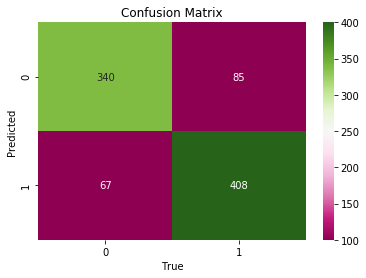

In [92]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', vmin=100, vmax=400, cmap="PiYG")
ax.set_xlabel('True');
ax.set_ylabel('Predicted'); 
ax.set_title('Confusion Matrix'); 


Widać, że model w równym stopniu mysli się nadając flagę pozytywny (1) negatywnym komentarzom oraz nadając flagę negatywny dla pozytywnych komentarzy.